In [1]:
from io import BytesIO
import json

import requests
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# Знакомство с функциональностью распознавания лиц

Для распознавания лиц используются четыре метода API:
- **set**:       позволяет установить связь между заданной фотографией и конкретным  person_id
- **recognize**: позволяет распознать person по заданной фотографии
- **delete**:    позволяет удалить связь между фотографией и person_id
- **truncate**:  позволяет полностью очистить space от внесенных person_id

В этом разделе демо, используя метод set, зададим определенный person_id для человека с фотографии. Затем с помощью метода recognize распознаем этого человека на других фотографиях.

Больше подробностей в документации: https://mcs.mail.ru/docs/ru/ml/vision/manage-vision/face-recognition

In [2]:
HOST = "https://smarty.mail.ru"
oauth_provider = "mcs"
# вставить свой токен. 
# Инструкция для получения токена: https://mcs.mail.ru/docs/ru/ml/vision/vision-start/auth-vision
oauth_token = "ВСТАВЬТЕ ВАШ ТОКЕН"  

# параметры запроса для авторизации при обращении к API
authorization_params = {
    "oauth_provider": oauth_provider, 
    "oauth_token": oauth_token
}


NAMESPACE_FOR_DEMO = "7"

In [3]:
def plot_image(image, figsize=(15, 15)):
    """Функция для отрисовки изображений внутри ноутбучка"""
    plt.figure(figsize=figsize)
    plt.imshow(image, interpolation="lanczos")
    plt.axis('off')

In [4]:
# Загрузка изображения, которое будет использовано для присвоения person_id
url = 'https://fr_demo_vision_vkcloud.hb.bizmrg.com/face_recognition/01_Set_Marshall.png'
r = requests.get(url, allow_redirects=True)

if r.status_code == 200:
    image_set_raw = r.content
    image_set = plt.imread(BytesIO(image_set_raw))

## Set
позволяет установить связь между заданной фотографией и конкретным person_id

In [5]:
ENDPOINT_SET = "/api/v1/persons/set"

URL_SET = HOST + ENDPOINT_SET
print(URL_SET)

https://smarty.mail.ru/api/v1/persons/set


In [6]:
def request_set(URL: str, img: bytes, person_id: int, space: str="0"):
    """Функция-обёртка для обращения к методу set"""
    
    # создать словарь с файлами для параметра files в post запросе
    files = {}
    name = "file_0"
    files[name] = img
    
    # создать meta: Параметры запроса передаются в формате JSON в теле запроса с name="meta"
    meta = {
        "space": space,
        "images": [{"name":name, "person_id": person_id}]
    }
    data = {'meta': json.dumps(meta)}
    
    # отправка запроса
    response = requests.post(URL, params=authorization_params, data=data, files=files)
    return response

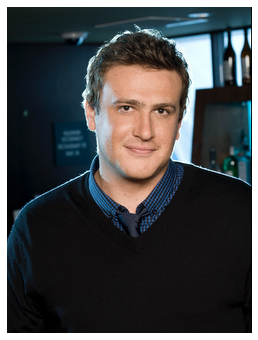

In [11]:
# Загрузка изображения, которое будет использовано для присвоения person_id
url = 'https://fr_demo_vision_vkcloud.hb.bizmrg.com/face_recognition/01_Set_Marshall.png'
r = requests.get(url, allow_redirects=True)

if r.status_code == 200:
    image_set_raw = r.content
    image_set = plt.imread(BytesIO(image_set_raw))
    plot_image(image_set, figsize=(6, 6))
else:
    print(f"Ошибка при получении файла. Код {r.status_code}")

In [13]:
# поставим в соответствие человеку с фотографии person_id=1 в неймспейсе 7
response = request_set(URL_SET, img=image_set_raw, person_id=1, space=NAMESPACE_FOR_DEMO)
response.json()

{'status': 200,
 'body': {'objects': [{'status': 0, 'name': 'file_0'}]},
 'htmlencoded': False,
 'last_modified': 0}

## Recognize

In [7]:
ENPOINT_RECOGNIZE = "/api/v1/persons/recognize"

URL_RECOGNIZE = HOST + ENPOINT_RECOGNIZE
print(URL_RECOGNIZE)

https://smarty.mail.ru/api/v1/persons/recognize


In [8]:
def request_recognize(URL: str, img: bytes, create_new: bool=False, space: str="0"):
    """Функция обертка для упрощенной отправки запроса к эндпойнту recognize"""
    
    # создать словарь с файлами для параметра files в post запросе
    files = {}
    name = "file_0"
    files[name] = img
    
    # создать meta: Параметры запроса передаются в формате JSON в теле запроса с name="meta"
    meta = {
        "space": space,
        "create_new": create_new,
        "images": [{"name":name}]
    }
    data = {'meta': json.dumps(meta)}
    
    # отправка запроса
    response = requests.post(URL, params=authorization_params, data=data, files=files)
    return response

In [9]:
def parse_persons_response(response):
    persons_list = response.json()['body']['objects'][0]['persons']
    persons_bb = []

    for person in persons_list:
        if person['tag'] == 'undefined':
            color = "r"
        elif person['tag'].startswith('person'):
            color="g"

        persons_bb.append((person['coord'], color))
    return persons_bb

In [10]:
def parse_coords_for_rectangle(coord: list[int]):
    """
    Необходимо вернуть в удобном для отрисовки в patches.Rectangle виде
    На вход подается список из 4 точек: [left x, top y, right x, bottom y]
    Также учесть инверсию оси Y изображения в API Vision и в matplotlib. Vision считает сверху, matplotlib - снизу
    """
    
    width = coord[2] - coord[0]
    height = coord[1] - coord[3]  # из-за инверсии оси Y 
    xy = (coord[0], coord[3])
    return xy, width, height

In [11]:
def plot_image_with_bb(image, bounding_boxes: list):
    """
    bounding_boxes: {
        "label_1": [left x, top y, right x, bottom y],
        ...
        "label_n": [left x, top y, right x, bottom y]
    }
    """
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(image, interpolation="lanczos")
    
    for coord, color in bounding_boxes:
        xy, width, height = parse_coords_for_rectangle(coord)
        rect = patches.Rectangle(xy, width, height, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
    plt.show()

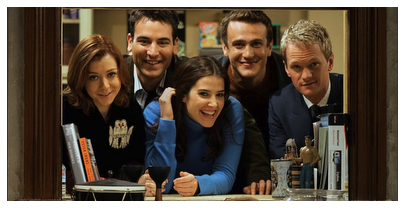

In [12]:
# Загрузка изображения для распознавания
url = "https://fr_demo_vision_vkcloud.hb.bizmrg.com/face_recognition/02_recognize_himym_all_1.png"
image_format = url.split(".")[-1]
r = requests.get(url, allow_redirects=True)

if r.status_code == 200:
    image_recognize_raw = r.content
    image_recognize = plt.imread(BytesIO(image_recognize_raw), format=image_format)
    plot_image(image_recognize, figsize=(7, 7))
else:
    print(f"Ошибка при получении файла. Код {r.status_code}")

In [13]:
response = request_recognize(URL_RECOGNIZE, img=image_recognize_raw, create_new=False, space=NAMESPACE_FOR_DEMO)
response.json()

{'status': 200,
 'body': {'objects': [{'status': 0,
    'name': 'file_0',
    'persons': [{'tag': 'undefined',
      'coord': [448, 54, 598, 247],
      'confidence': 0.99999,
      'awesomeness': 0.5511,
      'similarity': 1,
      'sex': 'male',
      'emotion': 'Happiness',
      'age': 30,
      'valence': 0.7104,
      'arousal': 0.0574,
      'frontality': 0.9653,
      'visibility': 0.9985},
     {'tag': 'undefined',
      'coord': [648, 243, 782, 426],
      'confidence': 0.99997,
      'awesomeness': 0.5594,
      'similarity': 1,
      'sex': 'female',
      'emotion': 'Happiness',
      'age': 30,
      'valence': 0.6997,
      'arousal': 0.1328,
      'frontality': 0.8944,
      'visibility': 0.9992},
     {'tag': 'undefined',
      'coord': [1012, 152, 1149, 318],
      'confidence': 0.99996,
      'awesomeness': 0.5455,
      'similarity': 1,
      'sex': 'male',
      'emotion': 'Contempt',
      'age': 31,
      'valence': -0.5315,
      'arousal': 0.6148,
      'front

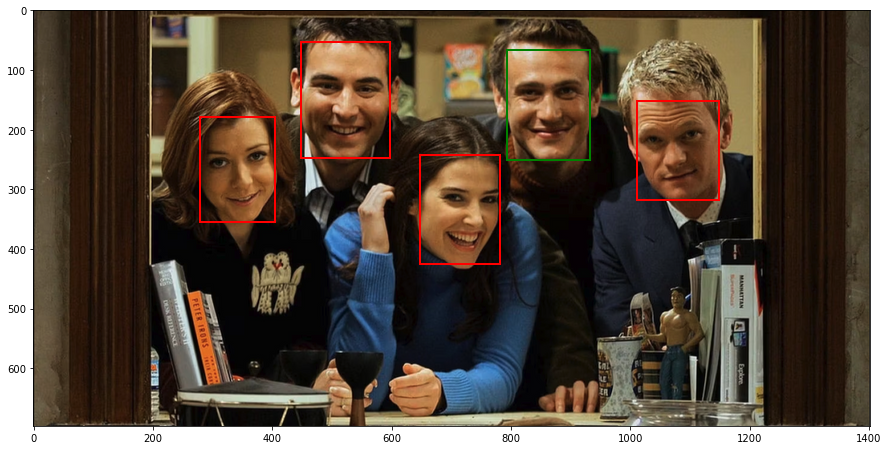

In [14]:
plot_image_with_bb(image_recognize, parse_persons_response(response))

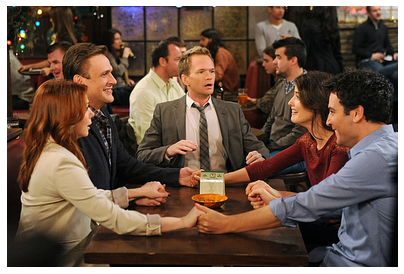

In [15]:
# Загрузка изображения для распознавания
url = "https://fr_demo_vision_vkcloud.hb.bizmrg.com/face_recognition/02_recognize_himym_all_2.jpeg"
image_format = url.split(".")[-1]
r = requests.get(url, allow_redirects=True)

if r.status_code == 200:
    image_recognize_raw = r.content
    image_recognize = plt.imread(BytesIO(image_recognize_raw), format=image_format)
    plot_image(image_recognize, figsize=(7, 7))
else:
    print(f"Ошибка при получении файла. Код {r.status_code}")

In [16]:
response = request_recognize(URL_RECOGNIZE, img=image_recognize_raw, create_new=False, space=NAMESPACE_FOR_DEMO)
response.json()

{'status': 200,
 'body': {'objects': [{'status': 0,
    'name': 'file_0',
    'persons': [{'tag': 'person1',
      'coord': [243, 149, 330, 292],
      'confidence': 0.99998,
      'awesomeness': 0.233,
      'similarity': 0.9155,
      'sex': 'male',
      'emotion': 'Happiness',
      'age': 41,
      'valence': 0.6386,
      'arousal': 0.0459,
      'frontality': 0.3905,
      'visibility': 0.9987},
     {'tag': 'undefined',
      'coord': [560, 158, 640, 275],
      'confidence': 0.99996,
      'awesomeness': 0.5089,
      'similarity': 1,
      'sex': 'male',
      'emotion': 'Surprise',
      'age': 44,
      'valence': -0.1775,
      'arousal': 0.3975,
      'frontality': 0.8644,
      'visibility': 0.9982},
     {'tag': 'undefined',
      'coord': [980, 263, 1066, 413],
      'confidence': 0.99987,
      'awesomeness': 0.2439,
      'similarity': 1,
      'sex': 'male',
      'emotion': 'Neutral',
      'age': 30,
      'valence': -0.0564,
      'arousal': 0.0844,
      'fronta

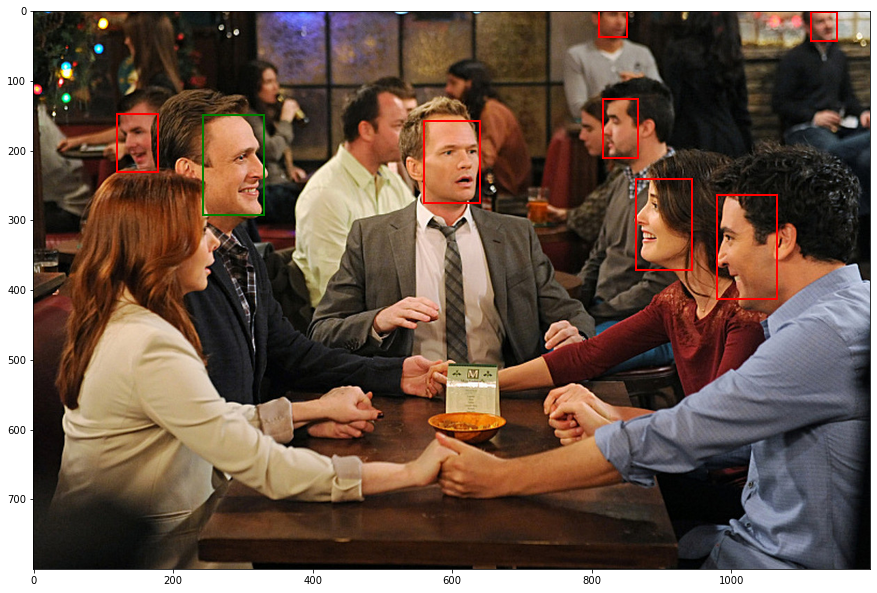

In [17]:
plot_image_with_bb(image_recognize, parse_persons_response(response))

# Попробуйте распознать свои фотографии

**Присвоить person_id определенному человеку**

In [18]:
# укажите путь до фотографии 
image_path_set = "./photo_examples/1_me.jpeg"
# укажите, какой person_id хотите присвоить этому человеку
person_id = 2

In [ ]:
with open(image_path_set, "rb") as image:
    image_set_raw = image.read()
image_set = plt.imread(image_path_set)
plot_image(image_set, figsize=(7, 7))

In [ ]:
# поставим в соответствие человеку с фотографии person_id
response = request_set(URL_SET, img=image_set_raw, person_id=person_id, space=NAMESPACE_FOR_DEMO)
response.json()

**Распознать этого человека на других фотографиях**

In [ ]:
# укажите путь до фотографии
image_path_recognize = "./photo_examples/3_birthday.jpg"

with open(image_path_recognize, "rb") as image:
    image_recognize_raw = image.read()
image_recognize = plt.imread(image_path_recognize)
plot_image(image_recognize, figsize=(7, 7))

In [ ]:
response = request_recognize(URL_RECOGNIZE, img=image_recognize_raw, create_new=False, space=NAMESPACE_FOR_DEMO)
response.json()

In [ ]:
plot_image_with_bb(image_recognize, parse_persons_response(response))